# **[Term Project] 자동차 생산 공정 데이터 분석을 통한 생산성 개선 방안 도출**

# 1. 문제 정의

* 제조 공정 데이터를 기반으로 생산성 향상에 미치는 유의미한 변수를 확인한다

# 2. 데이터 준비

## 1) 데이터 불러오기

In [ ]:
from google.colab import output

# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

output.clear()

# 설치 후 반드시 런타임 재시작 필요
! kill -9 $(ps -A | grep python | awk '{print $1}')

In [1]:
from google.colab import output
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from natsort import natsorted
import pandas as pd
import numpy as np

!gdown 1AX7tq815PP3FHIBrZZgYJZAt42cAAucf # process.xlsx
!gdown 13fUZ_74qQ9b1KhIlVRU7KuDygxCW6Nxa # worker.xlsx

output.clear()

In [2]:
plt.rc('font', family='NanumBarunGothic') # Colab
# plt.rc('font', family='AppleGothic') # Local : Mac
sns.set(font="NanumBarunGothic", rc={"axes.unicode_minus":False}, style='white')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
pd.set_option('display.max_columns', None)
path = '/content/drive/MyDrive/PortFolio'
import os

process_df = pd.read_excel(os.path.join(path, 'process.xlsx'))
worker_df = pd.read_excel(os.path.join(path, 'worker.xlsx'))
data = pd.merge(process_df, worker_df, left_on='작업자_사번', right_on='사번', how='left')

## 2) Data dictionary

| 변수명 | 정의 | 유형 | 설명 |
| --- | --- | --- | --- |
| 설비 | 작업이 진행된 설비 | str | LINE_A, LINE_B, LINE_C |
| 근무조 | 교대근무에 따른 근무조 | str | 야간, 주간 |
| 모델 | 생산 모델 | str | 니로, 소나타, 아반떼, 아이오닉, 투싼, 플러그인투싼 |
| 생산수량 | 생산 수량 | int | 해당 근무조의 생산량 |
| 가동률 | $\frac{가동시간}{조업시간}$ | float | 전체 조업시간 중 설비가 실제로 가동된 가동시간의 비율 |
| 시간가동률 | $\frac{가동시간}{부하시간}$ | float | 부하시간 중 설비의 고장 정지, 기종 변경, 자재 품절, 유실 기간 등의 정지시간을 제외한 가동시간과 부하시간의 비율로, 설비가 정지 없이 가동되고 있는가를 나타내는 지표 |
| 성능가동률 | $\frac{생산량 \times 단위생산시간}{가동시간}$ | float | (생산량 x 이론적 단위생산시간)/가동시간 으로, 가동시간 중 설비 목표 성능을 발휘한 시간의 비율 |
| 불량수량 | 생산 수량 중 불량 수량 | int |  |
| 작업자_사번 | 작업자 사번 | int |  |
| 사번 | 작업자 사번 | int |  |
| 성명 | 작업자 성명 | str |  |
| 나이 | 작업자 나이 | int |  |
| 성별 | 작업자 성별 | str | 남, 여 |
| 최종학력 | 작업자 최종학력 | str | 고등학교, 전문대학, 대학 |
| 입사일자 | 작업자 입사일자 | date | 연-월-일 |




- 조업시간
    - 1일 근무시간을 기초로 하루의 시업 시간과 종업 시간 사이의 총 시간
    - 휴식, 식사 수주물량 부족 등 `계획정지시간`을 포함
- 부하시간
    - `부하시간`=`조업시간` - `계획정지시간`
    - `조업시간`에서 `계획정지시간`을 제외하고 설비가 정상적인 상태에서 실제로 가동되어야 할 시간
- 가동시간
    - `가동시간` = `부하시간` - `정지시간`
    - 설비의 `부하시간`에서 `정지시간`을 제외한 시간으로, 설비가 실제 가동한 시간을 의미함.
    - `정지시간`이란 비계획적으로 설비의 작동이 정지된 시간으로 설비가 5분 이상 가동하지 않은 시간을 의미함.

### (1) 데이터 기본정보 확인

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2192 entries, 0 to 2191
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   작업일자    2192 non-null   datetime64[ns]
 1   설비      2192 non-null   object        
 2   근무조     2192 non-null   object        
 3   모델      2192 non-null   object        
 4   생산수량    1646 non-null   float64       
 5   가동률     1646 non-null   float64       
 6   시간가동률   1646 non-null   float64       
 7   성능가동률   1646 non-null   float64       
 8   불량수량    1646 non-null   float64       
 9   작업자_사번  1646 non-null   float64       
 10  사번      1646 non-null   float64       
 11  성명      1646 non-null   object        
 12  나이      1646 non-null   float64       
 13  성별      1646 non-null   object        
 14  최종학력    1646 non-null   object        
 15  입사일자    1646 non-null   object        
dtypes: datetime64[ns](1), float64(8), object(7)
memory usage: 291.1+ KB


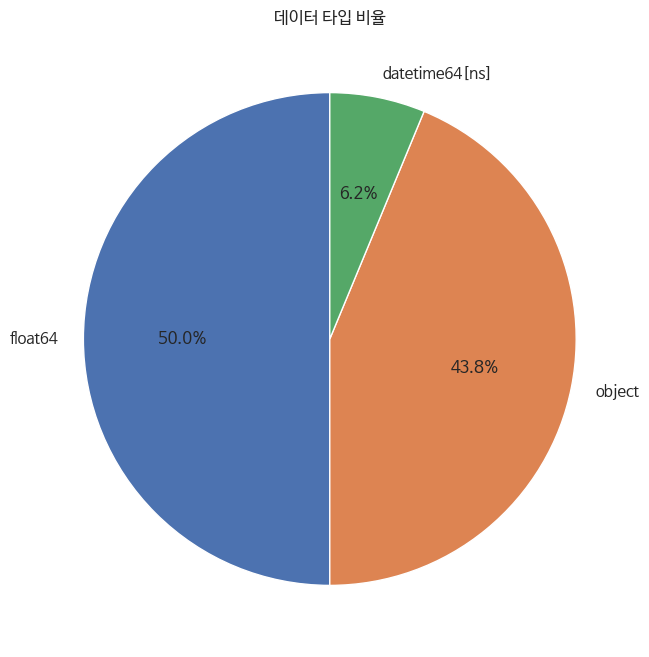

In [ ]:
# 데이터프레임의 데이터 타입 비율 계산
dtype_counts = data.dtypes.value_counts()

# 파이차트 생성
plt.figure(figsize=(8, 8))
plt.pie(dtype_counts, labels=dtype_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('데이터 타입 비율')
plt.show()

### (2) 결측치 확인

***`작업일자, 설비, 근무조, 모델`을 제외한 모든 칼럼에서 결측치가 546개씩 있는것을 확인***

In [ ]:
data.isnull().sum()

작업일자        0
설비          0
근무조         0
모델          0
생산수량      546
가동률       546
시간가동률     546
성능가동률     546
불량수량      546
작업자_사번    546
사번        546
성명        546
나이        546
성별        546
최종학력      546
입사일자      546
dtype: int64

<Figure size 1000x500 with 0 Axes>

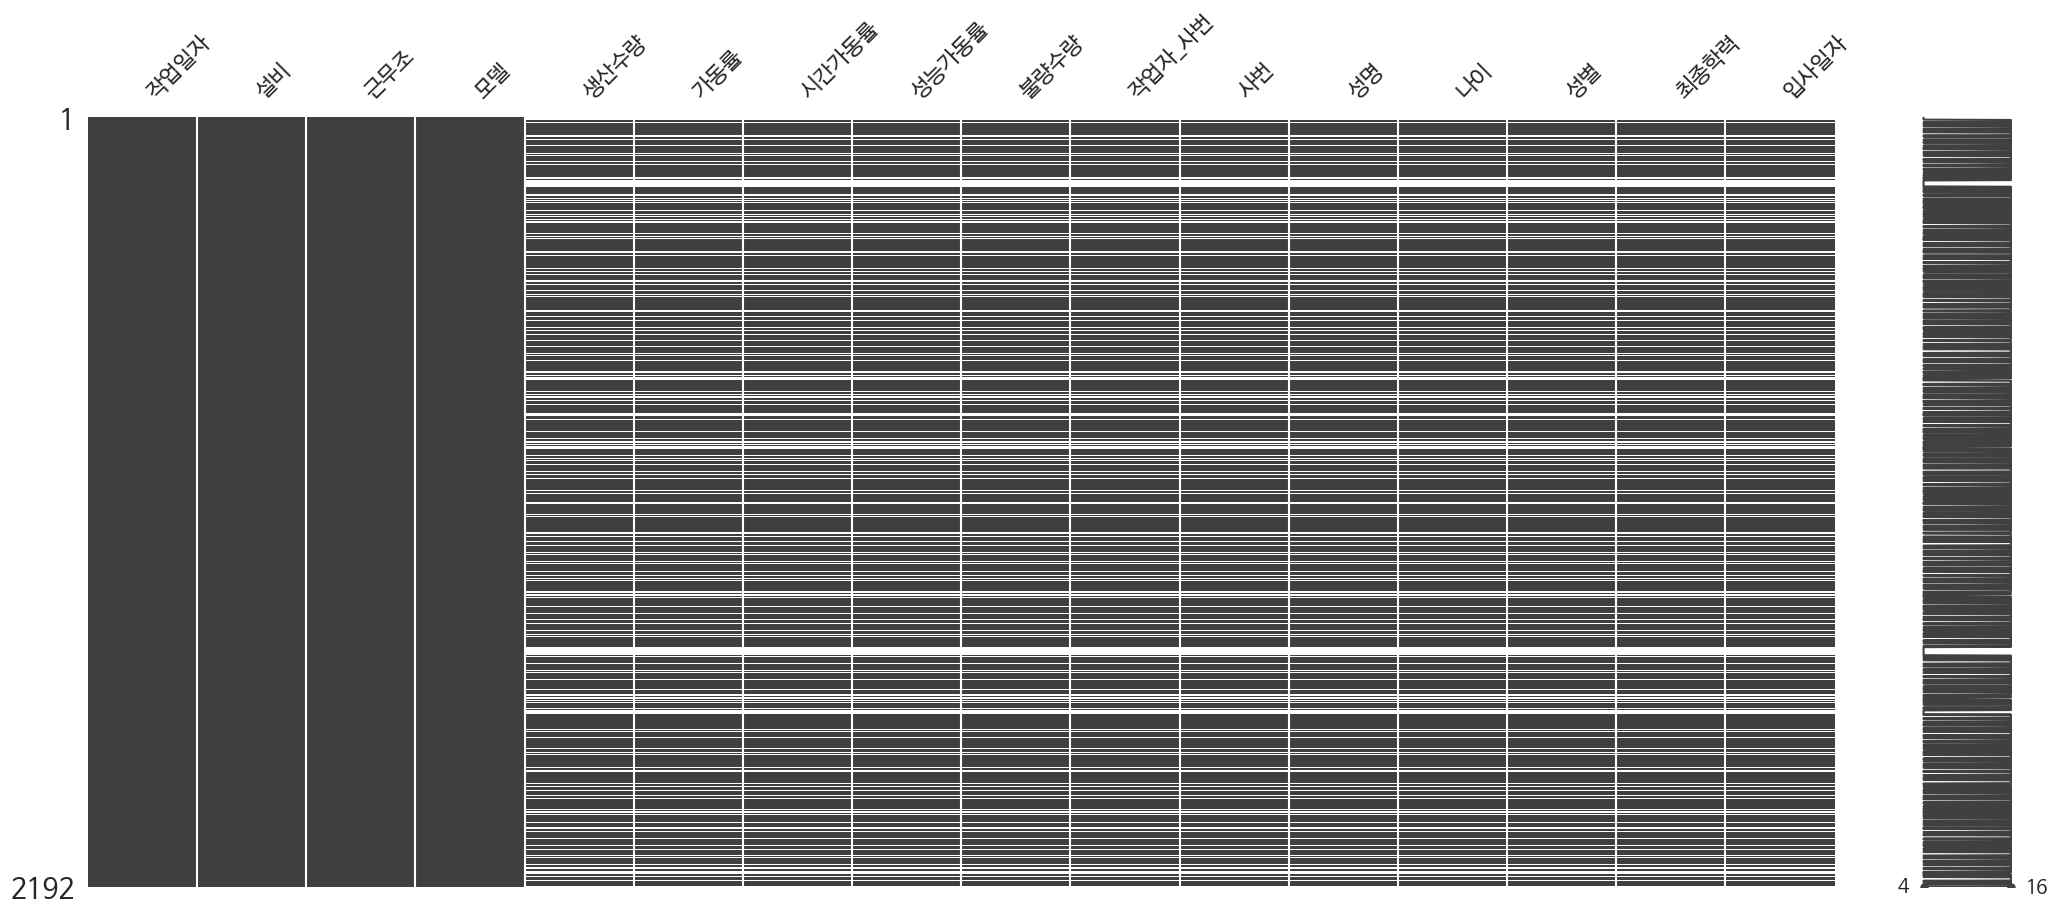

In [ ]:
try:
    import missingno as msno

except:
    !pip install missingno
    import missingno as msno

import seaborn as sns
#sns.set(font="NanumBarunGothic", # Colab
#        rc={"axes.unicode_minus":False}) # Colab
plt.figure(figsize=(10, 5))
msno.matrix(data.sort_values('작업일자'))
plt.show()

# 흰색 가로선 : 결측치

In [ ]:
# 결측치가 있는 column filtering
missing_col = data.isnull().sum()[data.isnull().sum().values > 0].index.tolist()
print(missing_col)

for col in missing_col:
    is_same = data['생산수량'].isnull().tolist() == data[col].isnull().tolist()
    print(is_same)

['생산수량', '가동률', '시간가동률', '성능가동률', '불량수량', '작업자_사번', '사번', '성명', '나이', '성별', '최종학력', '입사일자']
True
True
True
True
True
True
True
True
True
True
True
True


***👉  모든 칼럼의 동일한 행에 결측치가 있음을 확인함***

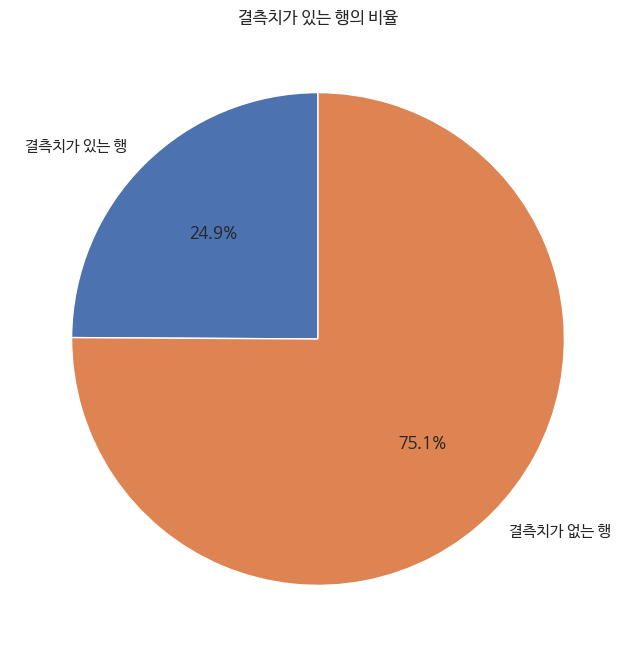

In [ ]:
# 결측치 비율 확인

# 각 행에 대한 결측치 여부 확인
missing_rows = data.isnull().any(axis=1)

# 결측치가 있는 행의 비율 계산
missing_rows_percentage = (missing_rows.sum() / len(data)) * 100

# 파이차트 생성
plt.figure(figsize=(8, 8))
plt.pie([missing_rows_percentage, 100 - missing_rows_percentage], labels=['결측치가 있는 행', '결측치가 없는 행'],
        autopct='%1.1f%%', startangle=90)
plt.title('결측치가 있는 행의 비율')
plt.show()


***데이터 전처리 : Missing Value(결측치)***
* 모든 값을 단순히 imputation(mean, mode, min, max) 하기에는 약 25%로 데이터에 큰 왜곡이 발생할 것으로 예상됨
* 따라서 drop 시키는 것이 최선일 것으로 판단

# 데이터 전처리

### 1) 결측치 제거


In [6]:
data = data.dropna(axis=0)

### 2) 겹치는 변수 제거

***`작업자_사번`, `사번`은 동일한 data를 가지고 있는 칼럼으므로 1개(`작업자_사번`) 삭제 함***

In [7]:
data.drop(['작업자_사번'], axis=1, inplace=True)

### 3) 데이터 타입 변환

1. 사번 : float -> int

2. 나이 : float -> int

In [8]:
# 결측치(Nan)는 int로 변환이 안되므로 결측치가 아닌 row들을 불러와 변환

data['사번'] = data['사번'].astype(int)
data['나이'] = data['나이'].astype(int)

In [9]:
data[['사번', '나이']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1646 entries, 8 to 2191
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   사번      1646 non-null   int64
 1   나이      1646 non-null   int64
dtypes: int64(2)
memory usage: 38.6 KB


👉 float >>> int 변경 확인

### 4) datetime64 분할

***작업일자, 입사일자 : datetime64 👉 년, 월, 일 별 분석이 가능하도록 분할***

In [10]:
# 분할 : year, month, day

data['작업일자_year'] = data['작업일자'].dt.year
data['작업일자_month'] = data['작업일자'].dt.month
data['작업일자_day'] = data['작업일자'].dt.day

data[['작업일자_year', '작업일자_month', '작업일자_day']].head()

,작업일자_year,작업일자_month,작업일자_day
8,2022,1,2
9,2022,1,2
10,2022,1,2
11,2022,1,2
12,2022,1,3


***`입사일자`는 현재 object type인 것을 확인 👉 datetime64 type으로 변환 후 분할 진행***

In [11]:
# 현재 object임

print(f'type : {data["입사일자"]}')

type : 8        1993-1-16
9         2018-6-1
10       1996-4-18
11       2014-4-20
12       2014-6-26
           ...    
2185     2018-6-26
2188     1993-9-17
2189    2008-11-30
2190     2018-6-26
2191     2001-3-23
Name: 입사일자, Length: 1646, dtype: object


In [12]:
# object -> datetime64으로 변환된 것을 확인

data["입사일자"] = pd.to_datetime(data["입사일자"], format='%Y-%m-%d')

# 분할 : year, month, day

data['입사일자_year'] = data['입사일자'].dt.year
data['입사일자_month'] = data['입사일자'].dt.month
data['입사일자_day'] = data['입사일자'].dt.day

data[['입사일자_year', '입사일자_month', '입사일자_day']][-5:]

,입사일자_year,입사일자_month,입사일자_day
2185,2018,6,26
2188,1993,9,17
2189,2008,11,30
2190,2018,6,26
2191,2001,3,23


### 5) 이상치 확인 및 제거

***Column 별 이상치 존재 확인***

***Column*** : 설비, 근무조, 모델, 생산수량, 가동률, 시간가동률, 성능가동률, 불량수량, 사번, 성명, 나이, 성별, 최종학력, 입사일자

***(1) 설비***

In [13]:
data['설비'].value_counts()

LINE_C    699
LINE_B    698
LINE_A    249
Name: 설비, dtype: int64

***(2) 근무조***

In [14]:
data['근무조'].value_counts()

주간    948
야간    698
Name: 근무조, dtype: int64

***(3) 모델***

In [15]:
data['모델'].value_counts()

투싼         616
플러그인투싼     442
아반떼        262
아이오닉       249
플러그인 투싼     44
소나타         28
니로           5
Name: 모델, dtype: int64

In [16]:
# '플러그인투싼' / '플러그인 투싼' => '플러그인투싼' 으로 통일해주기

old_word = '플러그인 투싼'
new_word = '플러그인투싼'

data['모델'] = data['모델'].replace(old_word, new_word, regex=True)

***(4) 생산수량***

<Axes: ylabel='Frequency'>

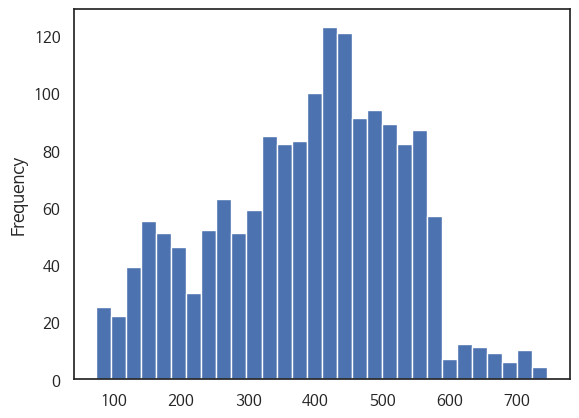

In [17]:
data['생산수량'].plot.hist(bins=30)

***(5) 가동률***

<Axes: ylabel='Frequency'>

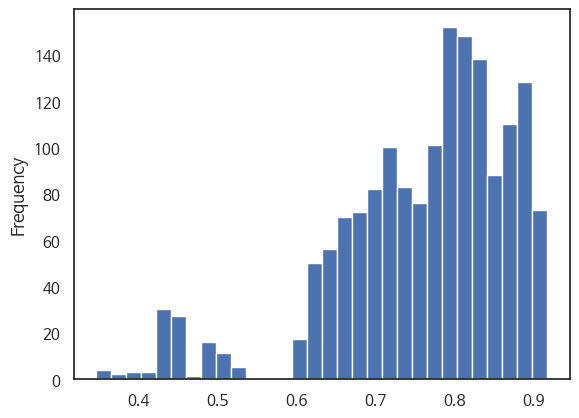

In [18]:
data['가동률'].plot.hist(bins=30)

***(6) 시간가동률***

<Axes: ylabel='Frequency'>

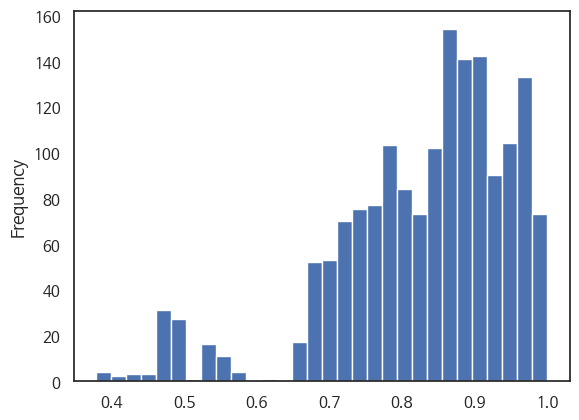

In [19]:
data['시간가동률'].plot.hist(bins=30)

***(7) 성능가동률***

<Axes: ylabel='Frequency'>

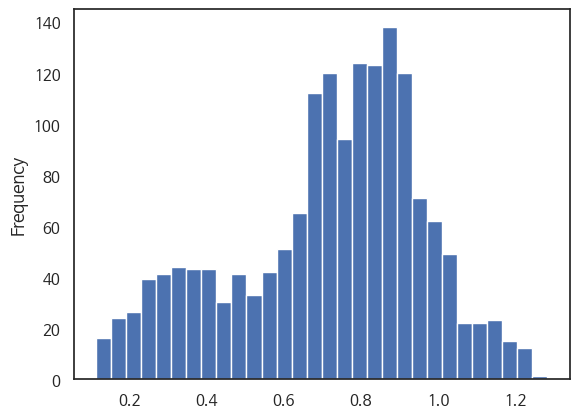

In [20]:
data['성능가동률'].plot.hist(bins=30)

***(8) 불량수량***

<Axes: ylabel='Frequency'>

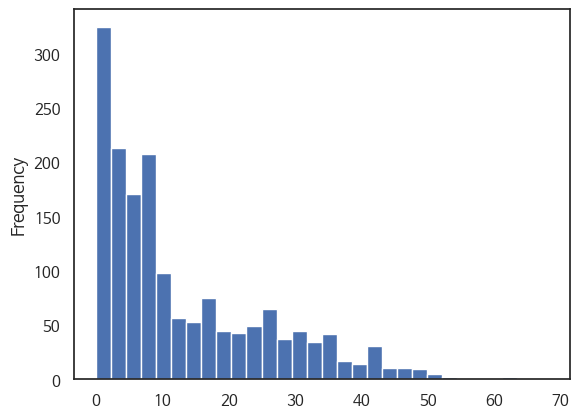

In [21]:
data['불량수량'].plot.hist(bins=30)

***(9) 사번***

<Axes: ylabel='Frequency'>

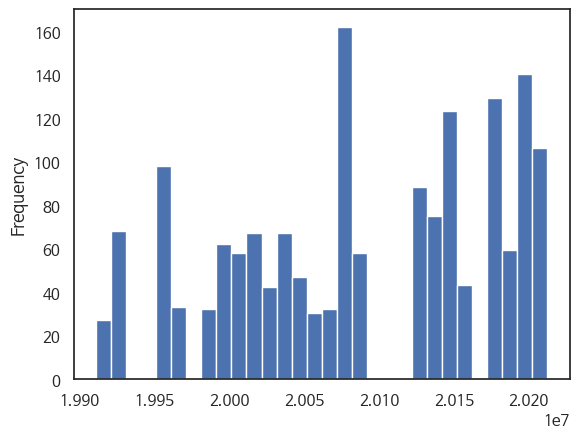

In [22]:
data['사번'].plot.hist(bins=30)

***(10) 성명***

In [23]:
data['성명'].value_counts

<bound method IndexOpsMixin.value_counts of 8       윤지후
9       강주원
10      최민규
11      정시후
12      손지우
       ... 
2185    이도윤
2188    이이안
2189    정승민
2190    이도윤
2191    홍현준
Name: 성명, Length: 1646, dtype: object>

***(11) 나이***

<Axes: ylabel='Frequency'>

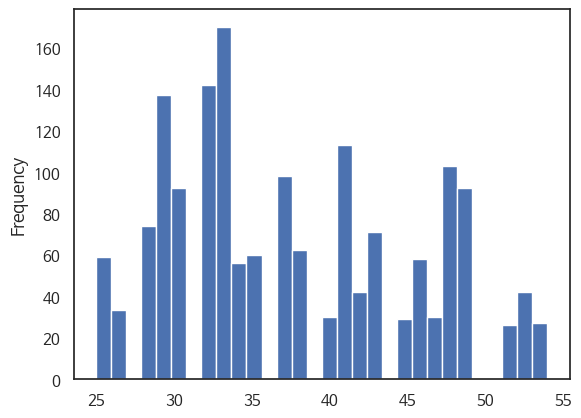

In [24]:
data['나이'].plot.hist(bins=30)

***(12) 성별***

In [25]:
data['성별'].value_counts()

남    1053
여     593
Name: 성별, dtype: int64

***(13) 최종학력***

In [26]:
data['최종학력'].value_counts()

고등학교    752
전문대학    460
대학      434
Name: 최종학력, dtype: int64

***(14) 입사일자***

In [27]:
data['입사일자'].value_counts()

2000-07-27    62
2005-05-13    47
2020-11-03    47
2015-08-08    43
2003-05-07    42
1993-01-16    42
2014-06-26    40
2019-05-12    40
2020-03-11    40
1996-06-22    39
2018-07-07    39
2001-03-23    38
2008-10-22    38
2007-03-11    36
2013-05-22    35
2014-07-20    34
2018-06-01    34
2004-06-01    34
2007-08-06    34
2018-11-16    34
1995-02-19    34
2020-02-21    33
1996-04-18    33
2003-10-22    33
2018-11-17    32
2021-09-26    32
2013-12-17    32
1998-06-09    32
2006-07-12    32
2009-06-20    32
2015-01-28    30
2015-09-29    30
2006-02-24    30
2001-09-21    29
2001-06-18    29
2014-04-20    29
2001-07-01    29
2013-04-08    28
2013-07-11    28
2008-11-30    28
2021-01-28    27
2020-04-28    27
1991-01-03    27
1993-09-17    26
2007-04-30    26
2008-07-15    26
2019-09-29    25
1995-12-23    25
2018-06-26    24
Name: 입사일자, dtype: int64

* ***간단한 시각화를 통해 확인해본 결과 일관성 차원의 이상치는 존재하지 않는 것으로 판단했습니다.***

### 6) 파생변수

* 근속년수 : 작업일자_year - 입사일자_year
* 불량률 : 불량수량 / 생산수량

In [28]:
data['근속년수'] = (data['작업일자_year'] - data['입사일자_year']).astype(int)
data['불량률'] = data['불량수량'] / data['생산수량']

* 나이 : 5살 단위로 구간화 진행
* 근속년수 : 5년 단위로 구간화 진행

In [29]:
bined_age = list()

for age in data['나이']:

    if age < 30:
        bined_age.append('25~29살')
    elif age < 35:
        bined_age.append('30~34살')
    elif age < 40:
        bined_age.append('35~39살')
    elif age < 45:
        bined_age.append('40~44살')
    elif age < 50:
        bined_age.append('45~49살')
    elif age < 55:
        bined_age.append('50~54살')
    else:
        bined_age.append(np.nan)

data['bined_나이'] = bined_age


work_year = list()

for wy in data['근속년수']:

    if wy < 5:
        work_year.append('00~04년')
    elif wy < 10:
        work_year.append('05~09년')
    elif wy < 15:
        work_year.append('10~14년')
    elif wy < 20:
        work_year.append('15~19년')
    elif wy < 25:
        work_year.append('20~24년')
    else:
        work_year.append('25 년 이상')

data['bined_근속년수'] = work_year

# 3. EDA

***목표***
1. 성능을 나타내는 변수들과 그 외 변수들 간의 유의미한 관계 확인
2. 결측치가 있는 행은 제거하고 EDA 수행
3. 데이터의 분포를 살펴본 후 결측치 처리 판단

"확인하고 또 확인하라" -데이터마이닝-  
  
데이터마이닝 시각화 수업자료 : https://ink-starfish-f66.notion.site/W04-13b5c69510bb42028bfda0f16549cdfb?pvs=4

## 👉  가설


| <font size="4">**가설 번호**</font> | <font size="4">**가설 설명**</font> | <font size="4">**도표**</font> |
| ----------------------------------- | ----------------------- | ----------------------- |
| <font size="4">생산수량-1</font> |  <font size="4">아반떼의 생산수량의 분산이 타 모델들에 비해 높을 것이다.</font> | <font size="4">EDA - 생산수량, 모델</font> |
| <font size="4">생산수량-2</font> |  <font size="4">LINE_A에서 22년 4월 29일~22년 8월 1일 사이에 평균 생산수량이 다른 날에 비해 높을 것이다.</font> | <font size="4">EDA - 생산수량, 4월 29일 ~ 8월 1일, 설비(LINE_A)</font> |
| <font size="4">불량률-1</font> |<font size="4">근속년수가 00-04년, 25년 이상인 경우 평균 불량률이 다른 년수에 비해 높을 것이다.</font> | <font size="4">EDA - 불량률, 근속년수</font> |
| <font size="4">시간가동률-1</font> | <font size="4">LINE_C에서 생산수량이 375개 이상일때 시간가동률이 높을 것이다.</font> | <font size="4">EDA - 시간가동률, 설비(LINE_C)</font> |


### 1) 기초통계량

In [30]:
data.describe()

,생산수량,가동률,시간가동률,성능가동률,불량수량,사번,나이,작업일자_year,작업일자_month,작업일자_day,입사일자_year,입사일자_month,입사일자_day,근속년수,불량률
count,1646.000000,1646.000000,1646.000000,1646.000000,1646.000000,1.646000e+03,1646.000000,1646.0,1646.000000,1646.000000,1646.000000,1646.000000,1646.000000,1646.000000,1646.000000
mean,386.518834,0.759977,0.828975,0.715881,12.916768,2.008885e+07,37.544957,2022.0,6.520656,15.974484,2008.722357,6.213244,16.865735,13.277643,0.033673
std,138.651322,0.111836,0.122146,0.246429,12.417499,8.774901e+04,7.939749,0.0,3.439693,8.726194,8.759818,3.013460,8.411503,8.759818,0.028480
min,74.000000,0.347000,0.379000,0.113323,0.000000,1.991102e+07,25.000000,2022.0,1.000000,1.000000,1991.000000,1.000000,1.000000,1.000000,0.000000
25%,289.000000,0.701559,0.765152,0.570660,3.000000,2.001179e+07,32.000000,2022.0,4.000000,8.000000,2001.000000,4.000000,11.000000,4.000000,0.010063
50%,404.500000,0.785990,0.857576,0.756960,8.000000,2.008130e+07,36.000000,2022.0,7.000000,16.000000,2008.000000,6.000000,18.000000,14.000000,0.019852
75%,488.000000,0.839036,0.915152,0.889597,20.000000,2.018015e+07,43.000000,2022.0,10.000000,23.000000,2018.000000,8.000000,23.000000,21.000000,0.057650
max,745.000000,0.917000,1.000000,1.282272,68.000000,2.021235e+07,54.000000,2022.0,12.000000,31.000000,2021.000000,12.000000,30.000000,31.000000,0.100775


### 2) 시각화

In [31]:
def make_plot_1(target_col, col):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    mean_values = data.groupby(col)[target_col].mean()
    hue_order_ = natsorted(data[col].sort_values().unique())

    # ax[0]
    ax_idx = 0
    mean_values.plot.bar(ax=ax[ax_idx])

    if target_col == '생산수량':

        max_mean = max(mean_values.values) + 20
        min_mean = min(mean_values.values) - 20

        for i, value in enumerate(mean_values):
            ax[ax_idx].text(i, value, f'{int(value)}개', ha='center', va='bottom')
        ax[ax_idx].set_ylim(min_mean, max_mean)
        ax[ax_idx].set_title(f'Mean {target_col}')

    else:
        max_mean = max(mean_values.values) + 0.015
        min_mean = min(mean_values.values) - 0.015

        for i, value in enumerate(mean_values):
            ax[ax_idx].text(i, value, f'{value * 100:.2f}%', ha='center', va='bottom')
        ax[ax_idx].set_ylim(min_mean, max_mean)
        ax[ax_idx].set_title(f'Mean {target_col}')

    # ax[1]
    ax_idx = 1
    sns.boxplot(data=data, x=col, y=target_col, hue=col, hue_order=hue_order_, ax=ax[ax_idx])
    ax[ax_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax[ax_idx].set_title(f'Boxplot {target_col}')

    # ax[2]
    ax_idx = 2
    #sns.histplot(data=data, x=target_col, hue=col, hue_order=hue_order_, ax=ax[ax_idx])
    sns.histplot(data=data, x=target_col, hue=col, ax=ax[ax_idx])
    #ax[ax_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax[ax_idx].set_title(f'Histogram {target_col}')

    plt.suptitle(f'{target_col} 평균 : {col} 별')
    plt.tight_layout()
    plt.show()

    if (col == '설비') & (target_col == '생산수량'):
        plt.figure(figsize=(18, 4))
        sns.lineplot(data=data, x='작업일자', y=target_col, hue=col, palette='pastel', hue_order=hue_order_)
        plt.title(f'작업일자 별 {target_col} | {col}')

In [32]:
def make_plot_2(data, target_col, col):

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    target_col_order = data[target_col].sort_values().unique()
    col_order = data[col].sort_values().unique()

    sns.countplot(data=data, x=target_col, hue=col, order=target_col_order, hue_order=col_order, ax=ax[0], palette='pastel')

    for p in ax[0].patches:
        if int(p.get_height()) > 0:
            ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, -10), textcoords='offset points', fontsize=12)

    ax[0].set_title(f'{target_col} count : {col}')
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')



    d = data[col].value_counts().sort_index()
    plt.pie(x=d.values, labels=d.index, colors=sns.color_palette('pastel'), autopct='%.1f%%')

    # sns.countplot(data=data, x=col, order=col_order, ax=ax[1], palette='pastel')
    # for p in ax[1].patches:
    #     if int(p.get_height()) > 0:
    #         ax[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
    #                     ha='center', va='center', xytext=(0, -10), textcoords='offset points', fontsize=14)

    ax[1].set_title(f'{col} Pie Plot')

    plt.tight_layout()
    plt.show()

In [33]:
def scatter_3D(data, col_x, col_y, col_z, col_hue, view_1, view_2, s):

    x1 = data[col_x]
    y1 = data[col_y]
    z1 = data[col_z]

    fig, ax = plt.subplots(2, 2, figsize=(18, 12), subplot_kw={'projection': '3d'})

    # 첫 번째 서브플롯
    axes = ax[0, 0]
    if col_hue is not None:
        unique_categories = data[col_hue].unique()
        num_categories = len(unique_categories)
        colors = plt.cm.rainbow(np.linspace(0, 1, num_categories))
        for i, category in enumerate(unique_categories):
            category_data = data[data[col_hue] == category]
            axes.scatter3D(category_data[col_x], category_data[col_y], category_data[col_z],
                           color=colors[i], label=category, s=s)
        axes.legend(title=col_hue, bbox_to_anchor=(1, 1), loc='upper left')
    else:
        axes.scatter3D(x1, y1, z1, s=s)
    axes.set_xlabel(col_x)
    axes.set_ylabel(col_y)
    axes.set_zlabel(col_z)
    axes.view_init(view_1, view_2)

    # 두 번째 서브플롯
    axes = ax[0, 1]
    if col_hue is not None:
        unique_categories = data[col_hue].unique()
        num_categories = len(unique_categories)
        colors = plt.cm.rainbow(np.linspace(0, 1, num_categories))
        for i, category in enumerate(unique_categories):
            category_data = data[data[col_hue] == category]
            axes.scatter3D(category_data[col_x], category_data[col_y], category_data[col_z],
                           color=colors[i], label=category, s=s)
        axes.legend(title=col_hue, bbox_to_anchor=(1, 1), loc='upper left')
    else:
        axes.scatter3D(x1, y1, z1, s=s)
    axes.set_xlabel(col_x)
    axes.set_ylabel(col_y)
    axes.set_zlabel(col_z)
    axes.view_init(0, 180)

    # 세 번째 서브플롯
    axes = ax[1, 0]
    if col_hue is not None:
        unique_categories = data[col_hue].unique()
        num_categories = len(unique_categories)
        colors = plt.cm.rainbow(np.linspace(0, 1, num_categories))
        for i, category in enumerate(unique_categories):
            category_data = data[data[col_hue] == category]
            axes.scatter3D(category_data[col_x], category_data[col_y], category_data[col_z],
                           color=colors[i], label=category, s=s)
        axes.legend(title=col_hue, bbox_to_anchor=(1, 1), loc='upper left')
    else:
        axes.scatter3D(x1, y1, z1, s=s)
    axes.set_xlabel(col_x)
    axes.set_ylabel(col_y)
    axes.set_zlabel(col_z)
    axes.view_init(0, 90)

    # 네 번째 서브플롯
    axes = ax[1, 1]
    if col_hue is not None:
        unique_categories = data[col_hue].unique()
        num_categories = len(unique_categories)
        colors = plt.cm.rainbow(np.linspace(0, 1, num_categories))
        for i, category in enumerate(unique_categories):
            category_data = data[data[col_hue] == category]
            axes.scatter3D(category_data[col_x], category_data[col_y], category_data[col_z],
                           color=colors[i], label=category, s=s)
        axes.legend(title=col_hue, bbox_to_anchor=(1, 1), loc='upper left')
    else:
        axes.scatter3D(x1, y1, z1, s=s)
    axes.set_xlabel(col_x)
    axes.set_ylabel(col_y)
    axes.set_zlabel(col_z)
    axes.view_init(90, 180)
    plt.suptitle(f'{col_x}, {col_y}, {col_z} | {col_hue}')

    plt.show()


#### (1) 생산수량

1. 모델
2. 근무조
3. 설비(LINE_A)

##### 1 생산수량, 모델

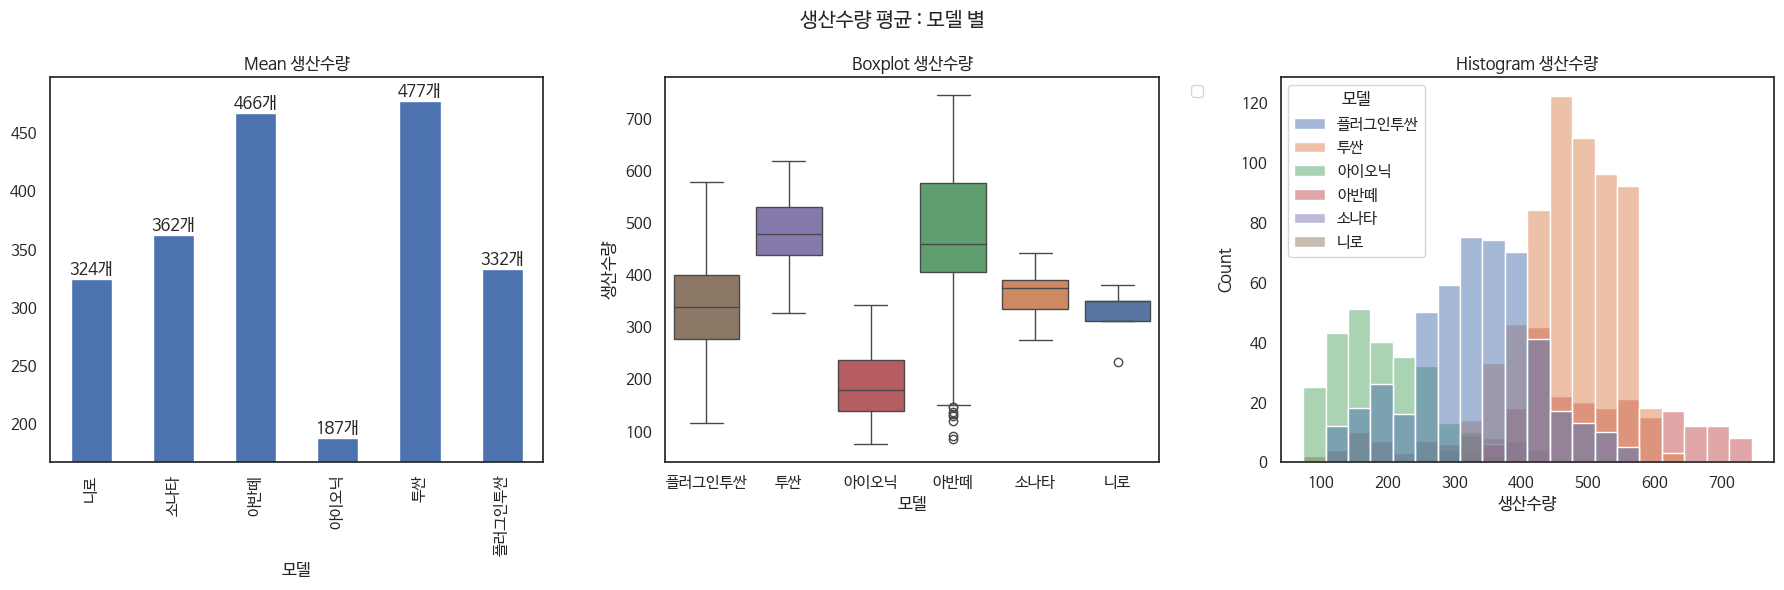

In [34]:
target_col = '생산수량'
col = '모델'

make_plot_1(target_col, col)

# 야간의 평균 생산수량이 주간의 평균 생산수량보다 70개 많다.

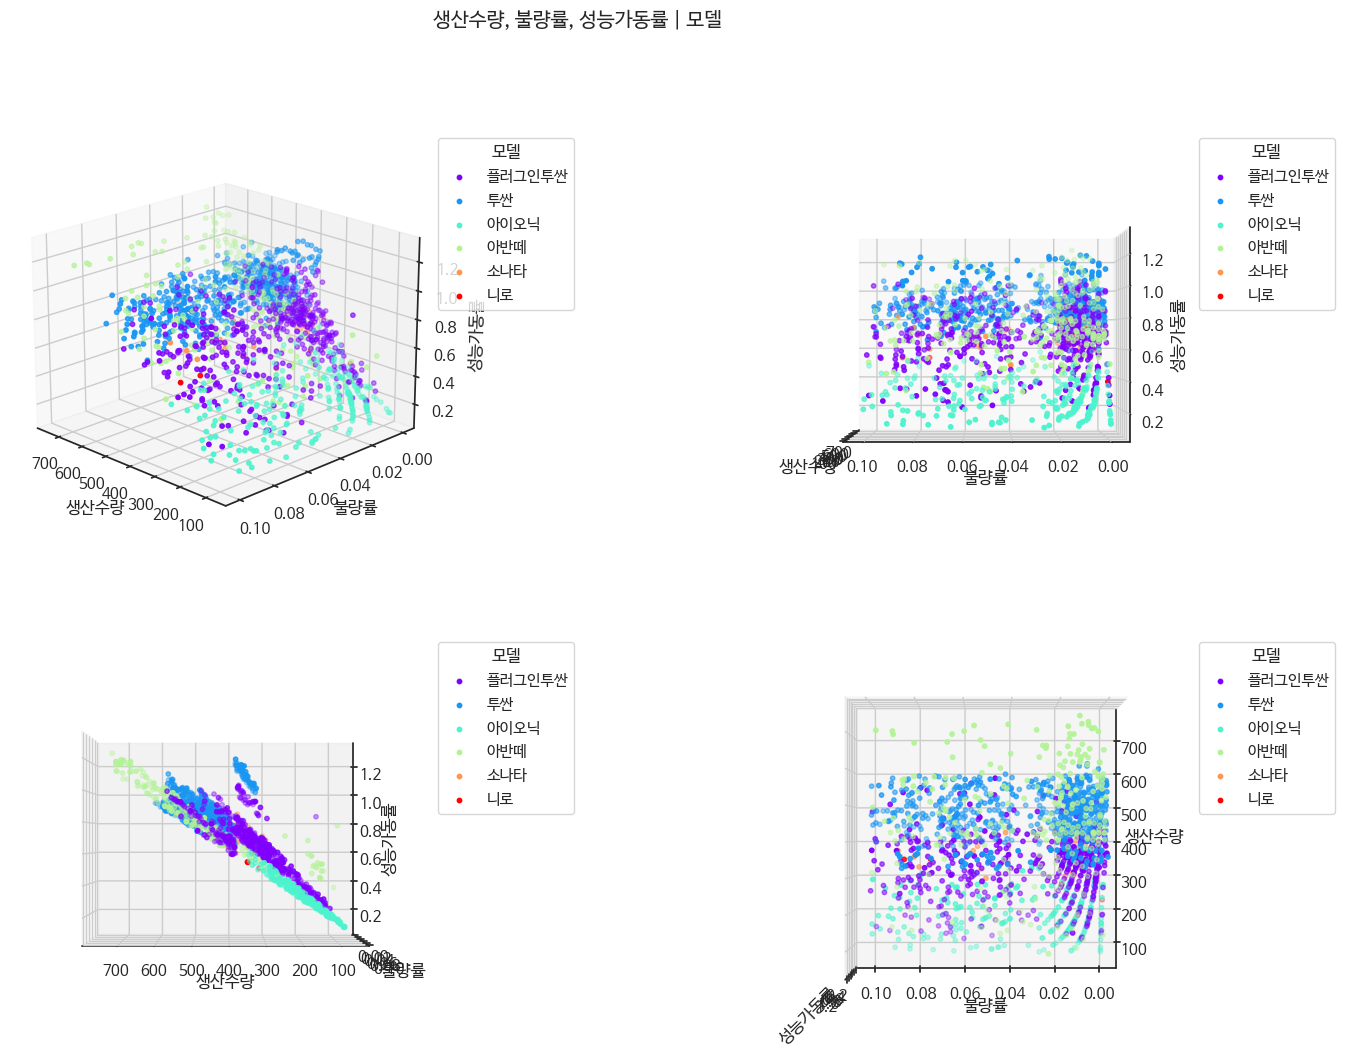

In [35]:
col_x = '생산수량'
col_y = '불량률'
col_z = '성능가동률'
col_hue = '모델'

scatter_3D(data, col_x, col_y, col_z, col_hue, 20, 135, 10)

# 아이오닉, 플러그인투싼 : 불량률이 0.03 이하, 성능 가동률이 0.6 이하인 경우 성능가동률이 낮아질수록 불량률이 높아지는 추세를 확인할 수 있다.

👉 가설 : 아반떼의 생산수량의 분산이 타 모델들에 비해 높을 것이다.

##### 2 생산수량, 4월 29일 ~ 8월 1일, 설비(LINE_A)

In [36]:
start_date = pd.to_datetime('2022-04-28')
end_date = pd.to_datetime('2022-08-02')

data_0429_0801 = data.loc[(start_date < data['작업일자']) & (data['작업일자'] < end_date)]
data_0429_0801_n = data.loc[(start_date >= data['작업일자']) | (data['작업일자'] >= end_date)]

print(f'{start_date} ~ {end_date} : {len(data_0429_0801)}')
print(f'{start_date} ~ {end_date} 외 : {len(data_0429_0801_n)}')

2022-04-28 00:00:00 ~ 2022-08-02 00:00:00 : 436
2022-04-28 00:00:00 ~ 2022-08-02 00:00:00 외 : 1210


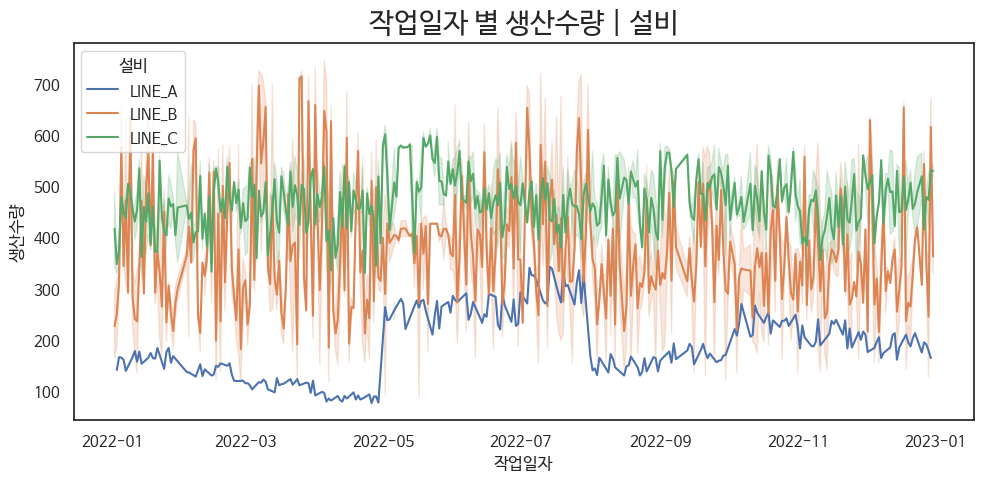

In [37]:
plt.figure(figsize=(10, 5))
sns.lineplot(data, x='작업일자', y='생산수량', hue='설비', hue_order=data['설비'].sort_values().unique())

plt.title('작업일자 별 생산수량 | 설비', y=1.01, fontsize=20)
plt.tight_layout()
plt.show()

# 22.04.29 ~ 22.08.01 사이에 LINE_A에서의 생산량이 크게 올랐다.

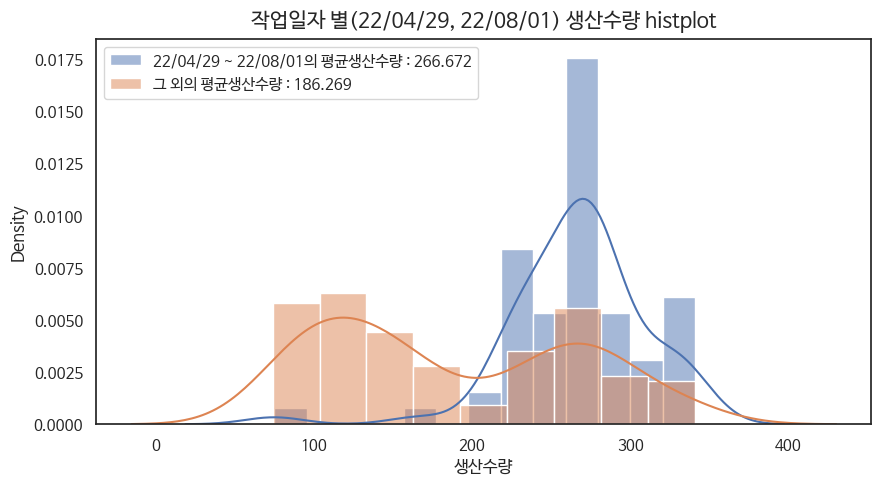

In [38]:
col_num = '생산수량'

data_0429_0801 = data[(data['작업일자'] > start_date ) & (end_date > data['작업일자']) & (data['설비']=='LINE_A')]
data_0429_0801_n = data[((data['작업일자'] <= start_date ) | (end_date > data['작업일자'])) & (data['설비']=='LINE_A')]

unique_category = ['22/04/29 ~ 22/08/01', '그 외']
h_samples = [data_0429_0801, data_0429_0801_n]

plt.figure(figsize=(10, 5))
for idx, cate in enumerate(unique_category):

    h_sample = h_samples[idx][col_num]
    ax = sns.histplot(h_sample, kde=True, stat="density", kde_kws=dict(cut=3),
                      label=f"{cate}의 평균{col_num} : {np.round(h_sample.mean(), 3)}")

plt.title('작업일자 별(22/04/29, 22/08/01) 생산수량 histplot', y=1.01, fontsize=15)
plt.legend()
plt.show()

👉 가설 : LINE_A에서 22년 4월 29일~22년 8월 1일 사이에 평균 생산수량이 다른 날에 비해 높을 것이다.

#### (2) 불량률


##### 1 불량률, 근속년수

불량수량 / 생산수량

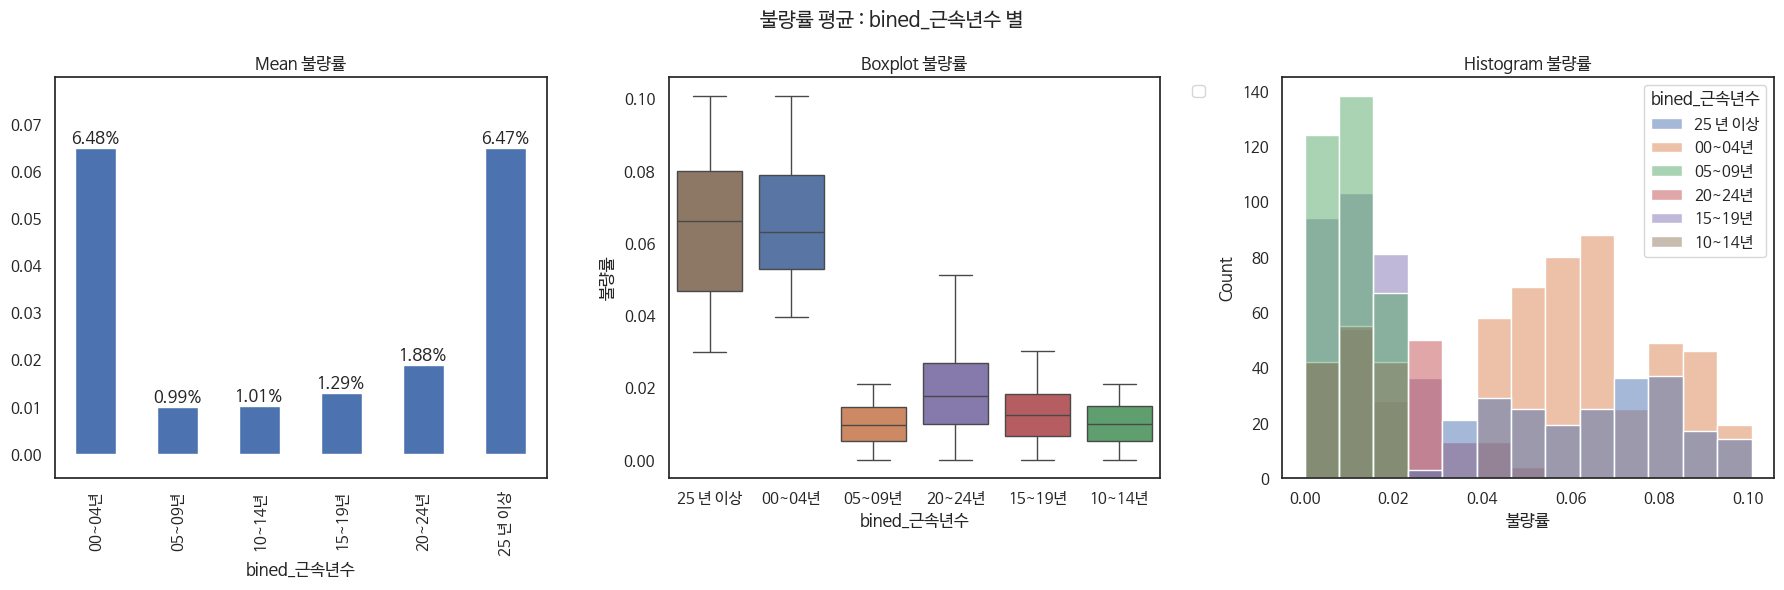

In [39]:
target_col = '불량률'
col = 'bined_근속년수'

make_plot_1(target_col, col)

# 근속년수가 00-04년, 25년 이상인 경우 불량률이 매우 높다.

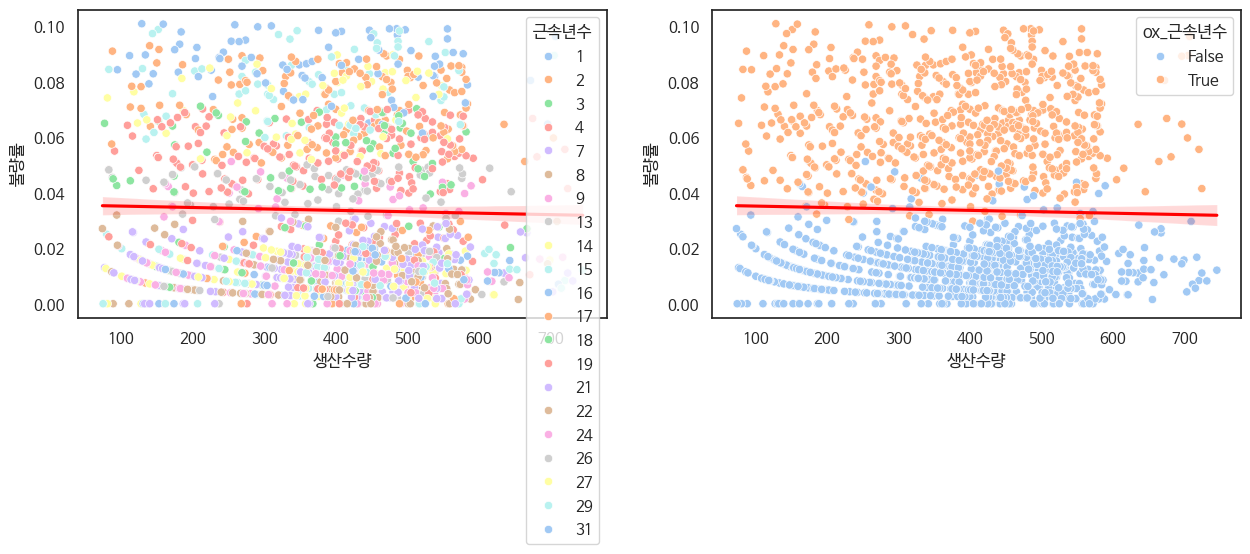

In [40]:
data['ox_근속년수'] = (data['bined_근속년수'] == '00~04년') | (data['bined_근속년수'] == '25 년 이상')

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.scatterplot(data=data, x='생산수량', y='불량률', hue='근속년수', ax=ax[0], palette='pastel')
sns.regplot(data=data, x='생산수량', y='불량률', scatter=False, color='red', ax=ax[0])

sns.scatterplot(data=data, x='생산수량', y='불량률', hue='ox_근속년수', ax=ax[1], palette='pastel')
sns.regplot(data=data, x='생산수량', y='불량률', scatter=False, color='red', ax=ax[1])

plt.show()

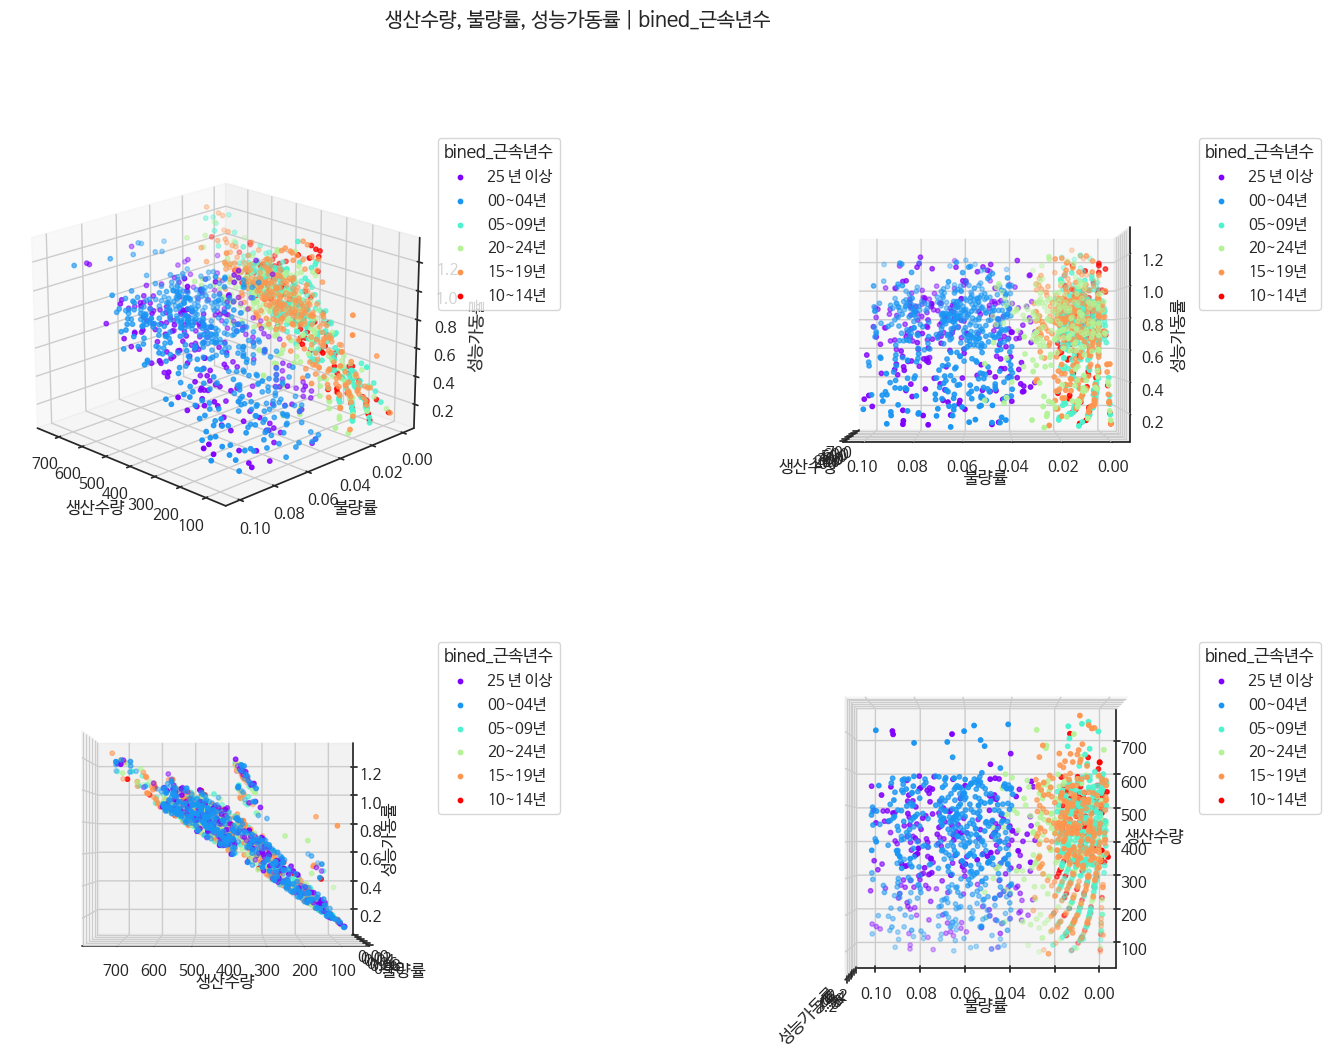

In [41]:
col_x = '생산수량'
col_y = '불량률'
col_z = '성능가동률'
col_hue = 'bined_근속년수'

scatter_3D(data, col_x, col_y, col_z, col_hue, 20, 135, 10)

# 00~04년, 25년이상인 경우 불량률이 높게 분포해 있다.
# 05~09년 10~14년 15~19년인 경우 불량률이 낮게 분포해 있다.
# 20~24년 : 불량률이 골고루 분포해 있다.
# 👉 나이보다 더 뚜렷하게 구분할 수 있음

# 불량률 0.03이하에서 3줄의 상관성은 주로 30~39살 사이에서 나타났다.

👉 가설 : 근속년수가 00-04년, 25년 이상인 경우 평균 불량률이 다른 년수에 비해 높을 것이다.

#### (3) 시간가동률

##### 1 시간가동률, 설비(LINE_C)  


 시간가동률 = $\frac{가동시간}{부하시간}$

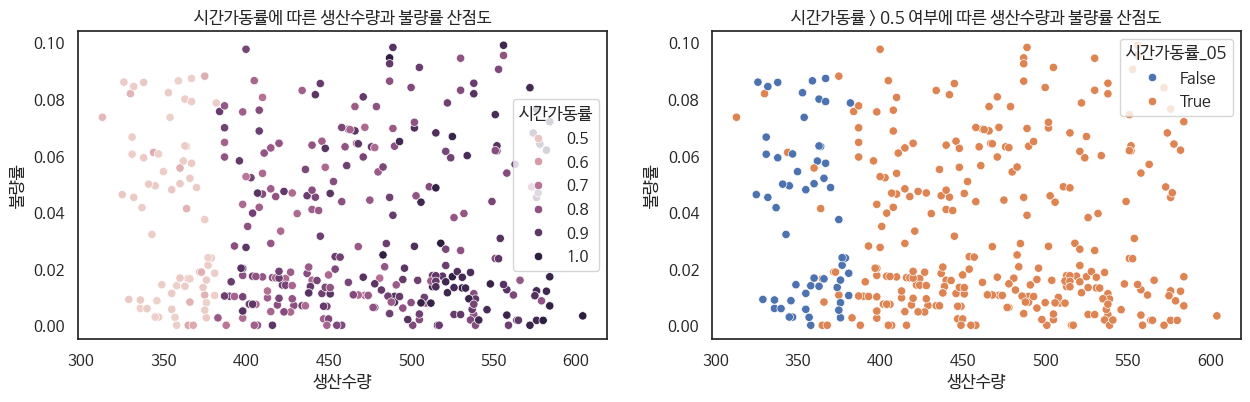

In [42]:
data['시간가동률_05'] = data['시간가동률'] > 0.5

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.scatterplot(data=data[(data['설비']=='LINE_C') & (data['근무조']=='주간')], x='생산수량', y='불량률', hue='시간가동률', ax=ax[0])
ax[0].set_title('시간가동률에 따른 생산수량과 불량률 산점도')

sns.scatterplot(data=data[(data['설비']=='LINE_C') & (data['근무조']=='주간')], x='생산수량', y='불량률', hue='시간가동률_05', ax=ax[1])
ax[1].set_title('시간가동률 > 0.5 여부에 따른 생산수량과 불량률 산점도')

plt.show()


👉 가설 : LINE_C에서 생산수량이 375개 이상일때 시간가동률이 높을 것이다.

생산수량이 375개 보다 낮은 경우 비효율적으로 생산이 이루어졌다고 생각해볼 수 있음

## 👉  가설


| <font size="4">**가설 번호**</font> | <font size="4">**가설 설명**</font> | <font size="4">**도표**</font> |
| ----------------------------------- | ----------------------- | ----------------------- |
| <font size="4">생산수량-1</font> |  <font size="4">아반떼의 생산수량의 분산이 타 모델들에 비해 높을 것이다.</font> | <font size="4">EDA - 생산수량, 모델</font> |
| <font size="4">생산수량-2</font> |  <font size="4">LINE_A에서 22년 4월 29일~22년 8월 1일 사이에 평균 생산수량이 다른 날에 비해 높을 것이다.</font> | <font size="4">EDA - 생산수량, 4월 29일 ~ 8월 1일, 설비(LINE_A)</font> |
| <font size="4">불량률-1</font> |<font size="4">근속년수가 00-04년, 25년 이상인 경우 평균 불량률이 다른 년수에 비해 높을 것이다.</font> | <font size="4">EDA - 불량률, 근속년수</font> |
| <font size="4">시간가동률-1</font> | <font size="4">LINE_C에서 생산수량이 375개 이상일때 시간가동률이 높을 것이다.</font> | <font size="4">EDA - 시간가동률, 설비(LINE_C)</font> |


# 4. 데이터 분석


## 분석계획


| 가설 번호 | 가설 | 검정방법 | 데이터 Type |
|-----------|-----|---------|------|
| <font size="4">생산수량-1</font> | <font size="4">아반떼의 생산수량의 분산이 타 모델들에 비해 높을 것이다.</font> | <font size="4">르빈의 등분산 검정</font> | <font size="4">명목형 / 연속형</font> |
| <font size="4">생산수량-2</font> | <font size="4">LINE_A에서 22년 4월 29일~22년 8월 1일 사이에 평균 생산수량이 다른 날에 비해 높을 것이다.</font> | <font size="4">독립표본 t 검정(단측)</font> | <font size="4">명목형 / 연속형</font> |
| <font size="4">불량률-1</font> | <font size="4">근속년수가 00-04년, 25년 이상인 경우 평균 불량률이 다른 년수에 비해 높을 것이다.</font> | <font size="4">독립표본 t 검정(단측), 분산분석(ANOVA)</font> | <font size="4">명목형 / 연속형</font> |
| <font size="4">시간가동률-1</font> | <font size="4">LINE_C에서 생산수량이 375개 이상일때 시간가동률이 높을 것이다.</font> | <font size="4">독립표본 t 검정(단측)</font> | <font size="4">명목형 / 연속형</font> |


In [43]:
from scipy.stats import levene

def one_way_Equal_Variance_test(col_cat, col_num, h0_name):

    unique_category = natsorted(data[col_cat].unique().tolist())

    unique_category.remove(h0_name)
    h_data = [data.loc[data[col_cat]==cate, col_num] for cate in unique_category]

    alpha = 0.05
    print(f'📍 단측 등분산검정')
    #print(f'📍 신뢰수준 : {(1-alpha)*100}%')
    print(f'📍 유의수준 : {alpha}')
    print(f'unique_category : {unique_category}')

    for idx, cate in enumerate(unique_category):
        print(f'\n\n<< {h0_name} / {cate} >>')
        statistic, p_value = levene(data.loc[data[col_cat]==h0_name, col_num], h_data[idx], center='median')
        #print(f"test statistic: {statistic}")
        print(f"P-value: {np.round(p_value, 9)}")

        if p_value < alpha:
            print('👉  대립가설 채택')
            print(f"👉  {h0_name}의 {col_num} 분산이 {cate}의 분산보다 크다.")
        else:
            print('👉  귀무가설 채택')
            print(f"👉  {h0_name}의 {col_num} 분산이 {cate}의 분산과 유의미한 차이가 없다.")

In [44]:
import scipy as sp

def one_way_independent_t_test(col_cat, col_num, h0_names):

    alpha = 0.05
    print(f'📍 단측 독립 t 검정')
    print(f'📍 유의수준 : {alpha}')

    if len(h0_names) > 1:

        for h0_name in h0_names:
            unique_category = natsorted(data[col_cat].unique().tolist())
            print(f'\n\n✅ {h0_name}')

            # 확인하고자 하는 대상 drop
            for h0_name_re in h0_names:
                unique_category.remove(h0_name_re)

            print(f'unique_category : {unique_category}')

            h_data = [data.loc[data[col_cat]==cate, col_num] for cate in unique_category]
            for idx, cate in enumerate(unique_category):
                print(f'\n<< {h0_name} / {cate} >>')
                statistic, p_value = sp.stats.ttest_ind(data.loc[data[col_cat]==h0_name, col_num], h_data[idx], equal_var=False)
                #print(f"test statistic: {statistic}")
                print(f"P-value: {np.round(p_value, 5)}")

                if p_value < alpha:
                    print('👉  대립가설 채택')
                    print(f"👉  {h0_name}의 {col_num} 평균이 {cate}의 평균보다 크다.")
                else:
                    print('👉  귀무가설 채택')
                    print(f"👉  {h0_name}의 {col_num} 평균이 {cate}의 평균과 유의미한 차이가 없다.")

    else:

        unique_category = natsorted(data[col_cat].unique().tolist())
        print(f'unique_category : {unique_category}')

        unique_category.remove(h0_names[0])
        h_data = [data.loc[data[col_cat]==cate, col_num] for cate in unique_category]

        for idx, cate in enumerate(unique_category):
            print(f'\n\n<< {h0_names[0]} / {cate} >>')
            statistic, p_value = sp.stats.ttest_ind(data.loc[data[col_cat]==h0_names[0], col_num], h_data[idx], equal_var=False)
            print(f"P-value: {np.round(p_value, 9)}")

            if p_value < alpha:
                print('👉  대립가설 채택')
                print(f"👉  {h0_names[0]}의 {col_num} 평균이 {cate}의 평균보다 크다.")
            else:
                print('👉  귀무가설 채택')
                print(f"👉  {h0_names[0]}의 {col_num} 평균이 {cate}의 평균과 유의미한 차이가 없다.")

In [45]:
from scipy.stats import f_oneway

def one_way_ANOVA(target_col, col):

    print('📍 분산분석(ANOVA)')
    print('📍 기각역 : 0.05')

    # 설비에 따른 데이터프레임 생성
    education_levels = data[col].unique().tolist()
    education_dfs = {level: data[data[col] == level] for level in education_levels}


    # 각 학력별 데이터프레임에 대해 불량수량의 차이에 대한 분산분석(ANOVA) 수행
    anova_result = f_oneway(*[df[target_col] for df in education_dfs.values()])

    # 결과 출력
    print("\n✅ ANOVA 결과:")
    print(f"F-statistic: {anova_result.statistic:.4f}")
    print(f"P-value: {anova_result.pvalue:.4f}\n")

    # 유의수준 설정
    alpha = 0.05

    # p-value가 유의수준보다 작으면 귀무가설 기각, 대립가설 채택
    if anova_result.pvalue < alpha:
        print(f'👉 대립가설 채택')
        print(f"{col}별 {target_col}의 평균에는 차이가 있다.")
    else:
        print(f'\n👉 귀무가설 채택')
        print(f"{col}별 {target_col}의 평균에는 차이가 없다.")

In [46]:
from scipy.stats import levene

def levene_test(target_col, col):

    print('📍 레빈의 등분산 검정')
    print('📍 기각역 : 0.05')

    # 설비에 따른 데이터프레임 생성
    education_levels = data[col].unique().tolist()
    education_dfs = {level: data[data[col] == level] for level in education_levels}

    # 각 학력별 데이터프레임에 대해 레빈의 등분산 검정 수행
    levene_result = levene(*[df[target_col] for df in education_dfs.values()])

    # 결과 출력
    print("\n✅ Levene's Test 결과:")
    print(f"W-statistic: {levene_result.statistic:.4f}")
    print(f"P-value: {levene_result.pvalue:.4f}\n")

    # 유의수준 설정
    alpha = 0.05

    # p-value가 유의수준보다 작으면 귀무가설 기각, 대립가설 채택
    if levene_result.pvalue < alpha:
        print(f'👉 대립가설 채택')
        print(f"{col}별 {target_col}의 분산에는 차이가 있다.")
    else:
        print(f'\n👉 귀무가설 채택')
        print(f"{col}별 {target_col}의 분산에는 차이가 없다.")


### 가설 : 생산수량-1
**아반떼의 생산수량의 분산이 타 모델들에 비해 높을 것이다.**  
  
**👉 levene의 등분산검정 : 모델 2개씩 비교**

$H_0$ : $s_{생산수량, 아반떼}^2 = s_{생산수량, model}^2$  for some $models$
  

$H_1$ : $s_{생산수량, 아반떼}^2 > s_{생산수량, model}^2$ for some $models$

In [47]:
# 등분산 검정
col_cat = '모델'
col_num = '생산수량'
h0_name = '아반떼'

one_way_Equal_Variance_test(col_cat, col_num, h0_name)

📍 단측 등분산검정
📍 유의수준 : 0.05
unique_category : ['니로', '소나타', '아이오닉', '투싼', '플러그인투싼']


<< 아반떼 / 니로 >>
P-value: 0.05424536
👉  귀무가설 채택
👉  아반떼의 생산수량 분산이 니로의 분산과 유의미한 차이가 없다.


<< 아반떼 / 소나타 >>
P-value: 3.786e-06
👉  대립가설 채택
👉  아반떼의 생산수량 분산이 소나타의 분산보다 크다.


<< 아반떼 / 아이오닉 >>
P-value: 0.0
👉  대립가설 채택
👉  아반떼의 생산수량 분산이 아이오닉의 분산보다 크다.


<< 아반떼 / 투싼 >>
P-value: 0.0
👉  대립가설 채택
👉  아반떼의 생산수량 분산이 투싼의 분산보다 크다.


<< 아반떼 / 플러그인투싼 >>
P-value: 0.0
👉  대립가설 채택
👉  아반떼의 생산수량 분산이 플러그인투싼의 분산보다 크다.


**👉 levene의 등분산검정 : 모든 모델 비교**

$H_0$ : $s_{생산수량, 아반떼}^2 = s_{생산수량, model}^2$  for some $models$
  

$H_1$ : $s_{생산수량, 아반떼}^2 \neq s_{생산수량, model}^2$ for some $models$

In [48]:
target_col = '생산수량'
col = '모델'

levene_test(target_col, col)

📍 레빈의 등분산 검정
📍 기각역 : 0.05

✅ Levene's Test 결과:
W-statistic: 58.7177
P-value: 0.0000

👉 대립가설 채택
모델별 생산수량의 분산에는 차이가 있다.


✅ 결론 : 대립가설 일부 채택
* 아반떼의 생산수량 분산이 니로를 제외한 다른 모델들의 분산보다 크다.
* 전체를 한 번에 검정했을 때는 모델별 분산에 차이가 있다는 결과

### 가설 : 생산수량-2
**LINE_A에서 22년 4월 29일~22년 8월 1일 사이에 평균 생산수량이 다른 날에 비해 높을 것이다.**  
**👉 독립표본 t 검정 (단측)**

$H_0$ : $\mu_{생산수량, 22.04.29 ~ 22.08.01} = \mu_{생산수량, 그\ 외\ 일자}$

$H_1$ : $\mu_{생산수량, 22.04.29 ~ 22.08.01} > \mu_{생산수량, 그\ 외\ 일자}$

In [49]:
col_num = '생산수량'

start_date = pd.to_datetime('2022-04-29')
end_date = pd.to_datetime('2022-08-01')

data_0429_0801 = data.loc[(data['작업일자'] > start_date) & (data['작업일자'] < end_date) & (data['설비']=='LINE_A')]
data_0429_0801_n = data.loc[(data['작업일자'] <= start_date ) | (data['작업일자'] >= end_date) & (data['설비']=='LINE_A')]

unique_category = ['22/04/29~22/08/01', '다른 날']
h_samples = [data_0429_0801, data_0429_0801_n]

print('📍 단측 독립 t 검정')
print('📍 기각역 : 0.05')

print(f'\nunique_category : {unique_category}')

print(f'\n\n<< {unique_category[0]} / {unique_category[1]} >>')
statistic, p_value = sp.stats.ttest_ind(h_samples[0][col_num], h_samples[1][col_num], equal_var=False)
print(f"P-value: {np.round(p_value, 9)}")

if p_value < 0.05:
    print('👉  대립가설 채택')
    print(f"👉  {unique_category[0]}때 LINE_A에서의 {col_num} 평균이 {unique_category[1]}의 평균보다 크다.")
else:
    print('👉  귀무가설 채택')
    print(f"👉  {unique_category[0]}때 LINE_A에서의 {col_num} 평균이 {unique_category[1]}의 평균과 유의미한 차이가 없다.")

📍 단측 독립 t 검정
📍 기각역 : 0.05

unique_category : ['22/04/29~22/08/01', '다른 날']


<< 22/04/29~22/08/01 / 다른 날 >>
P-value: 0.0
👉  대립가설 채택
👉  22/04/29~22/08/01때 LINE_A에서의 생산수량 평균이 다른 날의 평균보다 크다.


✅ 결론 : 대립가설 채택
1. 22/04/29~22/08/01때 LINE_A에서의 생산수량 평균이 다른 날의 평균보다 크다.

📍 이미 있어진 과거의 일이기에 22.04.31 ~ 22.08.01 시기의 데이터 다른 날짜와 비교해서 추론 검정을 진행하는 것이 모집단의 모수를 추론한다는 관점에서 옳은 것인지 의문이 있습니다.

### 가설 : 불량률-1
**근속년수가 00-04년, 25년 이상인 경우 평균 불량률이 다른 년수에 비해 높을 것이다.**

**👉 독립표본 t 검정 : 2개의 구간화된 근속년수를 비교**

  
1. 근속년수 : 00-04년
$ $  

    $H_0 : \mu_{불량률, 00-04년} = \mu_{불량률, bined\_\ 근속년수}$  for some 근속년수(25년 이상 제외)
  
    $H_1$ : $\mu_{불량률, 00-04년} > \mu_{불량률, bined\_\ 근속년수}$  for some 근속년수(25년 이상 제외)

2. 근속년수 : 25년 이상

    $H_0$ : $\mu_{불량률, 25년 이상} = \mu_{불량률, bined\_\ 근속년수}$  for some 근속년수(00-04년 제외)
  
    $H_1$ : $\mu_{불량률, 25년 이상} > \mu_{불량률, bined\_\ 근속년수}$  for some 근속년수(00-04년 제외)

In [50]:
# 독립표본 t 검정
col_cat = 'bined_근속년수'
col_num = '불량률'
h0_name = ['00~04년', '25 년 이상']

one_way_independent_t_test(col_cat, col_num, h0_name)

📍 단측 독립 t 검정
📍 유의수준 : 0.05


✅ 00~04년
unique_category : ['05~09년', '10~14년', '15~19년', '20~24년']

<< 00~04년 / 05~09년 >>
P-value: 0.0
👉  대립가설 채택
👉  00~04년의 불량률 평균이 05~09년의 평균보다 크다.

<< 00~04년 / 10~14년 >>
P-value: 0.0
👉  대립가설 채택
👉  00~04년의 불량률 평균이 10~14년의 평균보다 크다.

<< 00~04년 / 15~19년 >>
P-value: 0.0
👉  대립가설 채택
👉  00~04년의 불량률 평균이 15~19년의 평균보다 크다.

<< 00~04년 / 20~24년 >>
P-value: 0.0
👉  대립가설 채택
👉  00~04년의 불량률 평균이 20~24년의 평균보다 크다.


✅ 25 년 이상
unique_category : ['05~09년', '10~14년', '15~19년', '20~24년']

<< 25 년 이상 / 05~09년 >>
P-value: 0.0
👉  대립가설 채택
👉  25 년 이상의 불량률 평균이 05~09년의 평균보다 크다.

<< 25 년 이상 / 10~14년 >>
P-value: 0.0
👉  대립가설 채택
👉  25 년 이상의 불량률 평균이 10~14년의 평균보다 크다.

<< 25 년 이상 / 15~19년 >>
P-value: 0.0
👉  대립가설 채택
👉  25 년 이상의 불량률 평균이 15~19년의 평균보다 크다.

<< 25 년 이상 / 20~24년 >>
P-value: 0.0
👉  대립가설 채택
👉  25 년 이상의 불량률 평균이 20~24년의 평균보다 크다.


**👉 ANOVA : 모든 구간화된 근속년수를 비교**


$H_0$ : $\mu_{불량률, 근속년수} = \mu_{불량률, 근속년수}$  for some $구간화\ 된\ 근속년수$
  

$H_1$ : $\mu_{불량률, 근속년수} \neq \mu_{불량률, 근속년수}$ for some $구간화\ 된\ 근속년수$

In [51]:
target_col = '불량률'
col = 'bined_근속년수'

one_way_ANOVA(target_col, col)

📍 분산분석(ANOVA)
📍 기각역 : 0.05

✅ ANOVA 결과:
F-statistic: 1385.8033
P-value: 0.0000

👉 대립가설 채택
bined_근속년수별 불량률의 평균에는 차이가 있다.


✅ 결론 : 대립가설 채택

평균적으로 00-04년과 25년 이상 근무한 근무자들의 평균 불량률은 다른 년수보다 높다.


### 가설 : 시간가동률-1
**LINE_C에서 생산수량이 375개 이상일때 시간가동률이 높을 것이다.**

**👉 가설검정 : 독립표본 t 검정(단측)**  

$H_0 : \mu_{시간가동률, 생산수량\ 375개\ 이상} = \mu_{시간가동률, 생산수량 \ 375개\ 이하}$

$H_1$ : $\mu_{시간가동률, 생산수량\ 375개\ 미만} > \mu_{시간가동률, 생산수량 \ 375개\ 이하}$

In [52]:
col_num = '시간가동률'

start_date = data[data['생산수량'] > 375]
end_date = pd.to_datetime('2022-08-01')

data_375_up = data[(data['생산수량'] >= 375) & (data['설비'] == 'LINE_C')]
data_375_down = data[(data['생산수량'] < 375) & (data['설비'] == 'LINE_C')]

unique_category = ['375 이상', '375 미만']
h_samples = [data_375_up, data_375_down]

print('📍 단측 독립 t 검정')
print('📍 기각역 : 0.05')

print(f'\nunique_category : {unique_category}')

print(f'\n\n<< {unique_category[0]} / {unique_category[1]} >>')
statistic, p_value = sp.stats.ttest_ind(h_samples[0][col_num], h_samples[1][col_num], equal_var=False)
print(f"P-value: {np.round(p_value, 9)}")

if p_value < 0.05:
    print('👉  대립가설 채택')
    print(f"👉  생산수량이 {unique_category[0]}일 때 LINE_C 에서의 {col_num} 평균이 {unique_category[1]}의 평균보다 크다.")
else:
    print('👉  귀무가설 채택')
    print(f"👉  생산수량이 {unique_category[0]}일 때 LINE_C 에서의 {col_num} 평균이 생산수량이 {unique_category[1]}미만일 때의  평균과 유의미한 차이가 없다.")

📍 단측 독립 t 검정
📍 기각역 : 0.05

unique_category : ['375 이상', '375 미만']


<< 375 이상 / 375 미만 >>
P-value: 0.0
👉  대립가설 채택
👉  생산수량이 375 이상일 때 LINE_C 에서의 시간가동률 평균이 375 미만의 평균보다 크다.


✅ 결론 : 대립가설 채택
* 생산수량이 375 이상일 때 LINE_C 에서의 시간가동률 평균이 375 미만의 평균보다 크다.
* 생산수량이 375 미만이면 시간가동률이 0.5미만이 됨 = 조업시간 중 설비가 실제 움직인 시간 관점에서 매우 비효율 적임(정지시간이 많음)

# 5. 결론



| 가설 번호 | 가설 | 검정방법 | 결과 |
|-----------|-----|---------|------|
| <font size="4">생산수량-1</font> | <font size="4">아반떼의 생산수량의 분산이 타 모델들에 비해 높을 것이다.</font> | <font size="4">르빈의 등분산 검정</font> | <font size="4">참(아반떼 / 니로 = 기각)</font> |
| <font size="4">생산수량-2</font> | <font size="4">LINE_A에서 22년 4월 29일~22년 8월 1일 사이에 평균 생산수량이 다른 날에 비해 높을 것이다.</font> | <font size="4">독립표본 t 검정(단측)</font> | <font size="4">참</font> |
| <font size="4">불량률-1</font> | <font size="4">근속년수가 00-04년, 25년 이상인 경우 평균 불량률이 다른 년수에 비해 높을 것이다.</font> | <font size="4">독립표본 t 검정(단측), 분산분석(ANOVA)</font> | <font size="4">참</font> |
| <font size="4">시간가동률-1</font> | <font size="4">LINE_C에서 생산수량이 375개 이상일때 시간가동률이 높을 것이다.</font> | <font size="4">독립표본 t 검정(단측)</font> | <font size="4">참</font> |

<br>
<br>

## 분석 결과 활용성


### 1) 생산수량
1. **생산수량 1** : 아반떼의 생산수량의 분산이 타 모델들에 높을 것이다.    
    👉  아반떼의 **생산계획 최적화**를 통해 적절한(분산이 적게) 생산계획을 수립한다.
    👉  기존 생산계획(분산이 큰)에 맞게 **작업자를 유동적으로 배치**한다.
<br>
<br>
<br>
3. **생산수량 2** : LINE_A에서 22년 4월 29일~22년 8월 1일 사이에 평균 생산수량이 다른 날에 비해 높을 것이다.  
    👉  **생산수량을 적절하게 예측**해서 생산의 불균형을 최소화 한다.  
    👉  해당 기간에는 작업자의 피로를 분산시키기 위해 **더 많은 인력을 투입**하거나 **복리후생에 신경**쓴다.
<br>
<br>
<br>

### 2) 불량률

1. **불량률 1** : 근속년수가 00-04년, 25년 이상인 경우 평균 불량률이 다른 년수에 비해 높을 것이다.  
    👉  근속년수가 00-04년인 작업자들을 위한 **불량 예방을 위한 교육**을 기획한다.  
    👉  근속년수가 25년 이상인 작업자들은 **노하우나 기술을 교육하는 교육의 업무를 맡도록** 인력을 재배치한다.  
<br>
<br>
<br>

### 3) 시간가동률
1. **시간가동률 1** : LINE_C에서 생산수량이 375개 이상일때 시간가동률이 높을 것이다.  
    👉  생산수량이 375개 미만이 되면 **어떤 정지시간이 발생하는지 파악** 후 **로스타임을 줄여서 탄력적으로 생산을 수행**하도록 한다.  
